# Исследование рынка компьютерных игр

В текущей работе используется датасет с информацией о продаже игр, оценках пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры зкаономерности. В датасете представлены данные до 2016 года. ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

### Описание данных

16715 entries

Описательные характеристики:

* *Name* — название игры
* *Platform* — платформа
* *Year_of_Release* — год выпуска
* *Genre* — жанр игры
* *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
* *EU_sales* — продажи в Европе (миллионы проданных копий)
* *JP_sales* — продажи в Японии (миллионы проданных копий)
* *Other_sales* — продажи в других странах (миллионы проданных копий)
* *Critic_Score* — оценка критиков (максимум 100)
* *User_Score* — оценка пользователей (максимум 10)
* *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## 1. Предобработка данных 

Изучим и приведем данные к нужному виду

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import ceil
from matplotlib import rcParams
from scipy import stats as st

In [2]:
df = pd.read_csv('games.csv')

df.columns = df.columns.str.lower()

# Уберем заглавные буквы в строках 
df.platform = df.platform.str.lower()
df.genre = df.genre.str.lower()
df.name = df.name.str.lower()

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [5]:
df = df[~df.name.isna()]

In [6]:
df[df.user_score.isna()&df.critic_score.isna()&df.rating.isna()].shape[0]/ df.shape[0]

0.39603901154789684

В 40% данных пропуски по трем описательным характеристикам. Это очень много. Лучшая стратегия в данном случае - оставить пропуски. В случае года выпуска, можно заполнить отсуствующие значения основываясь в первую очередь на годах выхода данной игры на других платформах. 

In [7]:
types = df.name.unique()
for i in types:
    mean = df[df['name'] == i]['year_of_release'].mean()
    df.loc[df['name']==i,'year_of_release'] = df.loc[df['name']==i,'year_of_release'].fillna(mean)

# оставшиеся значения заполним медианой (среднее и медиана 2006 и 2007 соотв)
df.year_of_release = df.year_of_release.fillna(df.year_of_release.median())

In [8]:
# исследуем tbd
tbd = df[df.user_score == 'tbd']

tbd - значит to be discussed, рейтинг еще не исследован, слишком мало отзывов на metacritic или другом ресурсе где были получены оценки. Оставим без изменений, заменив на NaN

In [9]:
df.loc[df.user_score == 'tbd', 'user_score'] = np.nan

In [10]:
# Общие продажи на 3 рынках
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [11]:
df.year_of_release = df.year_of_release.apply('round')
df.year_of_release =df.year_of_release.astype('Int64')

## Исследовательский анализ данных.

Исследуем количество игр выпущенных в разные годы

<Figure size 720x576 with 0 Axes>

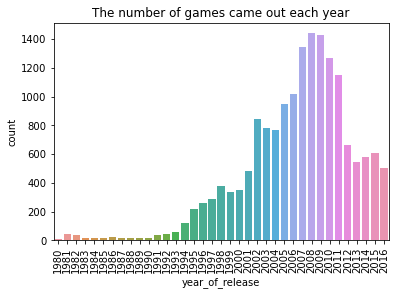

<Figure size 720x576 with 0 Axes>

In [12]:
sns.countplot(data =df, x = 'year_of_release').set(title='The number of games came out each year')
plt.xticks(rotation = 'vertical')
rcParams['figure.figsize'] = 6,4
plt.figure(figsize = (10,8))

Исследуем продажи за каждый год

[Text(0.5, 1.0, 'The number of sales each year')]

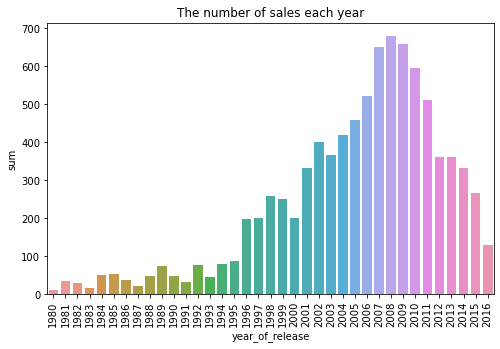

In [13]:
sales_year = df.groupby('year_of_release')['sales'].agg(['sum'])
rcParams['figure.figsize'] = 8,5
sns.color_palette('pastel')
plt.xticks(rotation = 'vertical')
sns.barplot(y="sum", x=sales_year.index, data=sales_year).set(title='The number of sales each year')


Видим спад в индустрии после 2011 года. По какой причине это случилось? Возможно индустрия вышла на поток, качество упало, многие разработчики покинули проекты. Также, мобильные игры появились в большом количестве. Либо в текущих данных не учтены онлайн продажи.

Видно что очень мало продаж и очень мало игр вышло до 2002 года. Можно в дальнейшем исключить годы до 1995 из рассмотрения. 

In [14]:
# Отбросим игры вышедшие ранее 2002 года
df = df[df.year_of_release >= 2002]

Исследуем продажи по платформам

<AxesSubplot:xlabel='sum', ylabel='platform'>

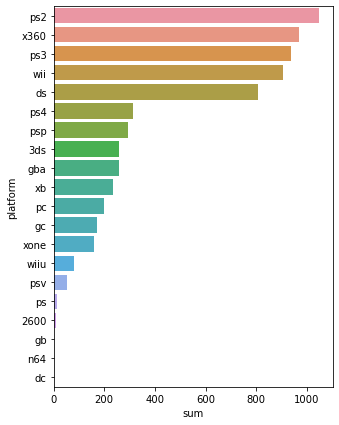

In [15]:
platforms_sales = df.groupby('platform')['sales'].agg(['sum']).sort_values(by = 'sum', ascending = False)
rcParams['figure.figsize'] = 5,7
sns.barplot(x="sum", y=platforms_sales.index, data=platforms_sales)

В топ 3 вышли PS2, Xbox 360 и PS3. Посмотрим распределения по годам для каждой из наиболее популярных платформ.

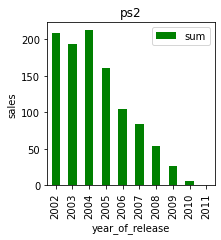

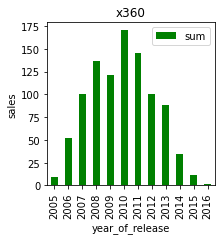

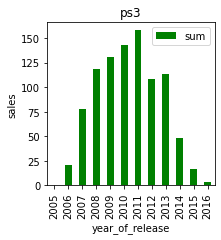

In [16]:
platfroms_best = ['ps2', 'x360', 'ps3']

rcParams['figure.figsize'] = 3,3

for i in platfroms_best: 
    graph = df[df.platform == i].groupby('year_of_release')['sales'].agg(['sum'])
    graph.plot.bar(color = 'green')
    plt.ylabel('sales')
    plt.title(i)
    plt.xticks(rotation = 'vertical')

In [17]:
t = {}
t_list = []
for i in df.platform.unique():
    graph = df[df.platform == i].groupby('year_of_release')['sales'].agg(['sum'])
    if graph.index.max() - graph.index.min() < 3:
        t[i] = graph.index.max() - graph.index.min()
        t_list.append(i)

In [18]:
# Данные платформы представлены на рынке менее 3 лет, исключим их из рассмотрения, данных мало
t_list

['2600', 'gb']

In [19]:
platf_dl = ['3do','pcfx', 'tg16','ng']

In [20]:
df = df[~df.platform.isin(t_list)]

Исследуем год выхода платформы (основываясь на данных)

In [21]:
platf_pivot = pd.pivot_table(df, values = ['year_of_release','sales'], index = 'platform', \
                             aggfunc={'year_of_release': 'max','sales': 'sum'})
platf_pivot.sort_values('year_of_release',ascending=False)

,sales,year_of_release
platform,,
3ds,259.00,2016
ps4,314.14,2016
x360,971.42,2016
wiiu,82.19,2016
wii,907.51,2016
psv,54.07,2016
ps3,939.17,2016
pc,199.35,2016
xone,159.32,2016


Пик продаж по топ 3 платформам приходится на ~7 лет. Можно использовать это значение как среднее время жизни платформы. Выделим акутальный период. Платформы, вышедшие в 2008 году уже потеряли акутальность в 2016. Так как в цель работы предоставить данные по рынку, актуальные к 2017 году, исключим их из рассмотрения. На эти игры не будет спроса.

In [22]:
inds_2008 = platf_pivot[platf_pivot['year_of_release'] >= 2008].index

In [23]:
# Актуальный период
print(df.shape)
df = df[df.platform.isin(inds_2008)]
print(df.shape)

(13884, 12)
(12604, 12)


Отбросим платформы, у которых не было продаж в 2016 году

In [24]:
olds = []
for i in df.platform.unique():
    graph = df[df.platform == i].groupby('year_of_release')['sales'].agg(['sum'])
    if int(graph.index.max()) < 2016:
        olds.append(i)

In [25]:
olds

['ds', 'ps2', 'xb', 'psp', 'dc']

In [26]:
print(df[df.platform.isin(olds)].shape[0]/df.shape[0])

0.47953030783878137


In [27]:
df = df[~df.platform.isin(olds)]
print(df.shape)

(6560, 12)


In [28]:
df.platform.unique()

array(['wii', 'x360', 'ps3', 'ps4', '3ds', 'pc', 'xone', 'wiiu', 'psv'],
      dtype=object)

In [29]:
# Также, можно было бы отбросить те строки,в которых продажи в 2016 меньше чем 10% от средних продаж

olds2 = []
for i in df.platform.unique():
    graph = df[df.platform == i].groupby('year_of_release')['sales'].agg(['sum'])
    if float(graph[graph.index == 2016]['sum']) < 0.1 * float(graph['sum'].mean()):
        olds2.append(i)
olds2

['wii', 'x360', 'ps3']

In [30]:
# Для дальнейших расчетов
df_stat = df.copy()

<AxesSubplot:xlabel='sum', ylabel='platform'>

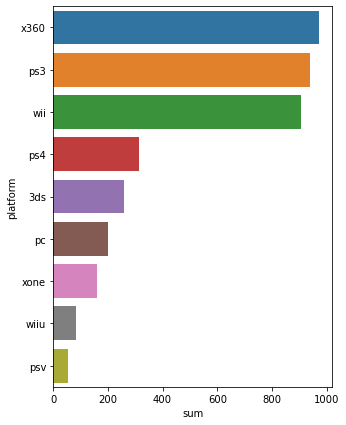

In [31]:
# Посмотрим на продажи
platforms_sales = df.groupby('platform')['sales'].agg(['sum']).sort_values(by = 'sum', ascending = False)
rcParams['figure.figsize'] = 5,7
sns.barplot(x="sum", y=platforms_sales.index, data=platforms_sales)


Самые перспективные платформы к 2017 году - ps4, 3ds, pc, xone.

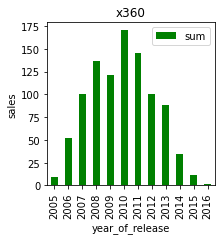

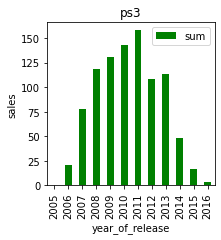

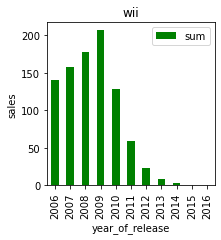

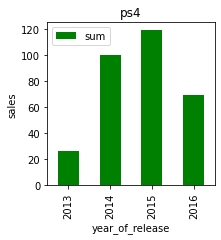

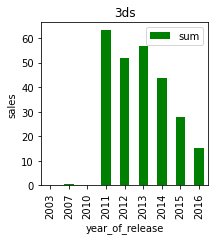

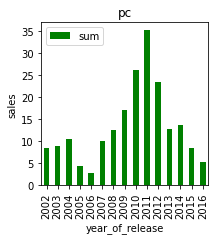

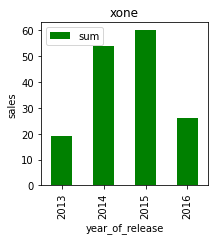

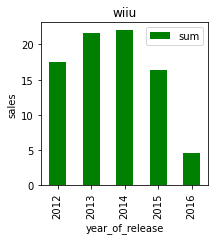

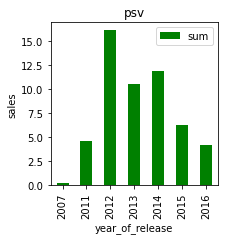

In [32]:
platfroms_best = platforms_sales.index

rcParams['figure.figsize'] = 3,3

for i in platfroms_best: 
    graph = df[df.platform == i].groupby('year_of_release')['sales'].agg(['sum'])
    graph.plot.bar(color = 'green')
    plt.ylabel('sales')
    plt.title(i)
    plt.xticks(rotation = 'vertical')

Видно как падали продажи playstation в связи с выходом новой версии. Так спад ps2 в 2008 переходит в рост продаж для ps3, также как и смена в 2013 на ps4. Самую большую прибыль за все время принесла платформа ps2, составляя 1.3 млрд (1255 млн) проданных копий. 

WII как проект вышедший в 2016, для которого было продано 82 млн копий, быстро потерял свою популярность по сравнению с другими платформами, будучи на пике 4-5 лет. Также как nintendo DS, пики продаж для которого пришлись на 2005-2010 года. 

<AxesSubplot:xlabel='platform', ylabel='sales'>

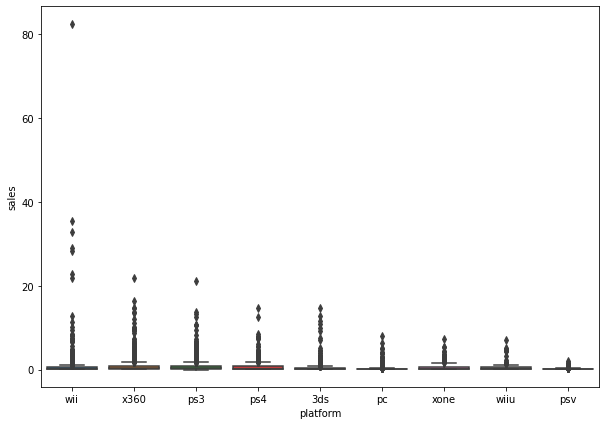

In [33]:
rcParams['figure.figsize'] = 10,7

sns.boxplot(data = df, x = 'platform', y = 'sales')

<AxesSubplot:xlabel='platform', ylabel='sales'>

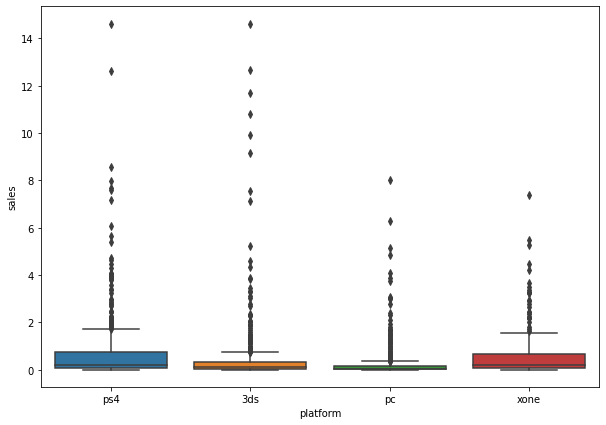

In [34]:
sns.boxplot(data = df[df.platform.isin(['ps4', '3ds', 'pc', 'xone'])], x = 'platform', y = 'sales')

На boxplot очень многие данные выходят за пределы 1,5 IQR сверху. В данных очень много значений с выбивающимися значениями продаж. Так на примере ПС2 видно что для каждой игры из серии ГТА было продано более 13 млн копий, тогда как в среднем игры на PS2 продаются в размере 0.23 млн копий. Таковы особенности индустрии.

Видно что медианы распределений по каждой платформе примерно равны. Разницу между платформами можно обосновать разными факторами. Так, например, в случае PC история продаж самая большая за все время. Игры продаются с 1995 до 2016, наблюдаютя как спады, так и подъемы, данные разнообразные. В случае 3ds, есть данные за 2003 год, но продаж практически не было вплоть до 2011. Тогда как для xone и wiiu распределения ближе к нормальному

Посмотрим как отличаются оценки критиков и пользователей

In [35]:
df.user_score = df.user_score.astype('Float64')

<AxesSubplot:xlabel='user_score', ylabel='sales'>

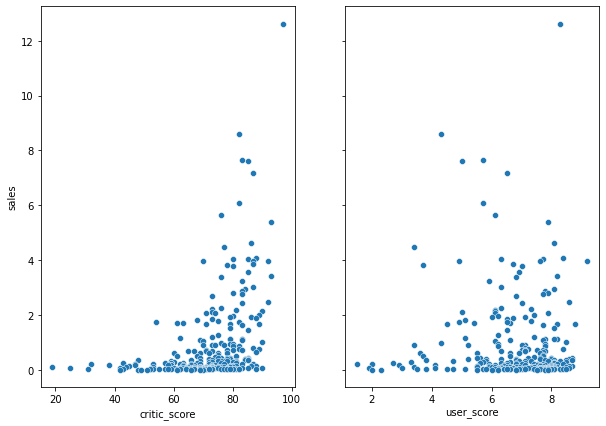

In [36]:
ps4 = df[df.platform == 'ps4']

fig, (ax0, ax1) = plt.subplots(1,2, sharey = True)

sns.scatterplot(data = ps4, x = 'critic_score', y = 'sales', ax = ax0)
sns.scatterplot(data = ps4, x = 'user_score', y = 'sales', ax = ax1)

In [37]:
ps4[['user_score','critic_score', 'sales']].corr()

,user_score,critic_score,sales
user_score,1.000000,0.557654,-0.031957
critic_score,0.557654,1.000000,0.406568
sales,-0.031957,0.406568,1.000000


Интересно, но оценки критиков не особо коррелируют с оценками пользователей. Также между продажами и оценками обоих групп нет никакой корреляции

Исследуем как обстоят дела на других платформах

<AxesSubplot:xlabel='user_score', ylabel='sales'>

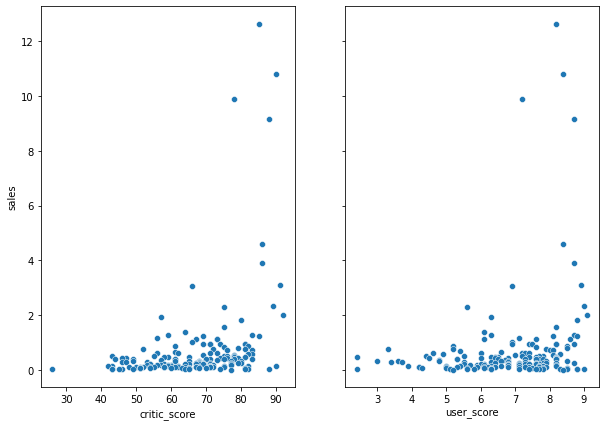

In [38]:
p3ds = df[df.platform == '3ds']

fig, (ax0, ax1) = plt.subplots(1,2, sharey = True)

sns.scatterplot(data = p3ds, x = 'critic_score', y = 'sales', ax = ax0)
sns.scatterplot(data = p3ds, x = 'user_score', y = 'sales', ax = ax1)

In [39]:
p3ds[['user_score','critic_score', 'sales']].corr()

,user_score,critic_score,sales
user_score,1.000000,0.744168,0.224808
critic_score,0.744168,1.000000,0.349401
sales,0.224808,0.349401,1.000000


В случае 3ds оценки критиков и пользователей коррелируют между собой

<AxesSubplot:xlabel='user_score', ylabel='sales'>

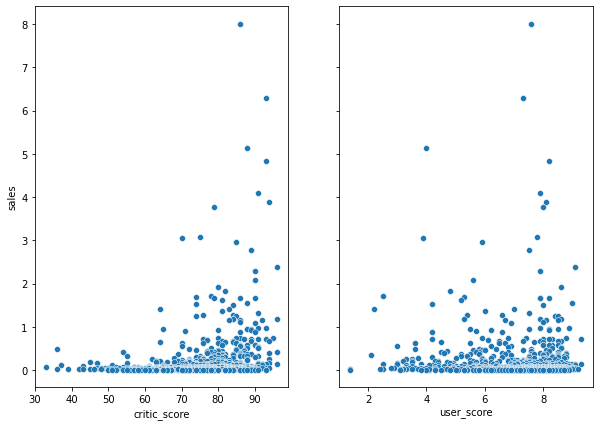

In [40]:
pc = df[df.platform == 'pc']

fig, (ax0, ax1) = plt.subplots(1,2, sharey = True)

sns.scatterplot(data = pc, x = 'critic_score', y = 'sales', ax = ax0)
sns.scatterplot(data = pc, x = 'user_score', y = 'sales', ax = ax1)

In [41]:
pc[['user_score','critic_score', 'sales']].corr()

,user_score,critic_score,sales
user_score,1.000000,0.543695,-0.014155
critic_score,0.543695,1.000000,0.252496
sales,-0.014155,0.252496,1.000000


В общем и целом, схожее соотношение наблюдается и для других платформ. 

Из данных сможно сделать вывод что ни оценка пользователей, ни оценка критиков не влияет на продажи. Однако, возможно между этими величинами зависимость есть, но она описывается сложнее и коэффициент корреляции Пирсона не информативен.

In [42]:
df.groupby('genre')['sales'].agg(['sum']).sort_values(by = 'sum' ,ascending=False)

,sum
genre,
action,910.52
shooter,693.66
sports,667.40
misc,399.33
role-playing,342.74
racing,248.55
platform,195.23
fighting,142.64
simulation,131.22


Среди наиболее популярных жанров определенно можно выделить экшн, спорт, шутеры и рпг как наиболее прибыльные жанры. Паззлы и стратегии совсем не популярны (Однако, их разработка сильно дешевле. Окупаемость таких игр может быть весьма значимой).

Рассмотрим популярность различных платформ и жанров на трех представленных рынках

In [43]:
# NA

In [44]:
na_sales = df.groupby('platform')['na_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
na_sales/df[~df.rating.isna()].na_sales.sum()

,sum
platform,
x360,0.353454
wii,0.291519
ps3,0.230851
ps4,0.063795
xone,0.054631


In [45]:
na_genre = df.groupby('genre')['na_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
na_genre/df[~df.rating.isna()].na_sales.sum()

,sum
genre,
action,0.249859
shooter,0.211426
sports,0.199886
misc,0.130541
role-playing,0.081548


In [46]:
# EU

In [47]:
eu_sales = df.groupby('platform')['eu_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
eu_sales/df[~df.rating.isna()].eu_sales.sum()

,sum
platform,
ps3,0.297883
x360,0.244549
wii,0.236827
ps4,0.127432
pc,0.109034


In [48]:
eu_genre = df.groupby('genre')['eu_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
eu_genre/df[~df.rating.isna()].eu_sales.sum()

,sum
genre,
action,0.277480
shooter,0.212359
sports,0.203354
misc,0.101889
racing,0.091205


In [49]:
# JP

In [50]:
jp_sales = df.groupby('platform')['jp_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
jp_sales/df[~df.rating.isna()].jp_sales.sum()

,sum
platform,
3ds,0.539612
ps3,0.429835
wii,0.371623
psv,0.117442
ps4,0.085549


In [51]:
jp_genre = df.groupby('genre')['jp_sales'].agg(['sum']).sort_values(by = 'sum',ascending=False).head(5)
jp_genre/df[~df.rating.isna()].jp_sales.sum()

,sum
genre,
role-playing,0.425493
action,0.396012
sports,0.167131
misc,0.144940
platform,0.121033


Видно что европейский и американский рынок не сильно отличаются по предпочтениям и продажам. В обеих регионах популярны одни и те же платформы и жанры. 

Японский рынок сильно отличается от остальных. Жанр РПГ там популярнее всех остальных, особенно по сравнению с Европой и Северной Америкой. А Xbox вообще не популярен, что довольно логично. Playstation производит Sony - японская фирма. Вполне объяснимо, что именно эти платформы будут лидировать на японском рынке. Видно что предпочтения и ожидания игроков из разных стран отличаются.

In [52]:
df.rating = df.rating.fillna('отсутствует')

In [53]:
df.rating.value_counts()

отсутствует    1896
T              1436
E              1336
M              1044
E10+            841
EC                4
RP                3
Name: rating, dtype: int64

In [54]:
ratings = df.groupby('rating')[['na_sales', 'eu_sales','jp_sales']].agg(['sum'])
ratings[('eu_sales', 'sum')]=ratings[('eu_sales', 'sum')]/df.eu_sales.sum()
ratings[('na_sales', 'sum')]=ratings[('na_sales', 'sum')]/df.na_sales.sum()
ratings[('jp_sales', 'sum')]=ratings[('jp_sales', 'sum')]/df.jp_sales.sum()

ratings

,na_sales,eu_sales,jp_sales
,sum,sum,sum
rating,,,
E,0.290180,0.278013,0.251338
E10+,0.125651,0.107907,0.043259
EC,0.000376,0.000000,0.000000
M,0.295426,0.307294,0.129014
RP,0.000000,0.000063,0.000000
T,0.191711,0.174479,0.170680
отсутствует,0.096656,0.132243,0.405708


<AxesSubplot:xlabel='rating', ylabel="('jp_sales', 'sum')">

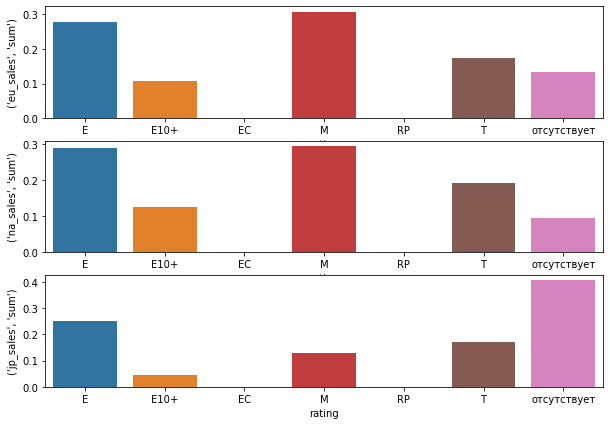

In [55]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
rcParams['figure.figsize'] = 9,7

sns.barplot(data = ratings, y = ('eu_sales', 'sum'), x = ratings.index,ax=ax0)
sns.barplot(data = ratings, y = ('na_sales', 'sum'), x = ratings.index,ax=ax1)
sns.barplot(data = ratings, y = ('jp_sales', 'sum'), x = ratings.index,ax=ax2)


Проверим, есть ли статистически значимое отличие между оценками пользователями игр на X360 и PC.

In [56]:
# Код студента
df_stat.user_score = df_stat.user_score.astype('Float64')

pc = df_stat[df_stat.platform == 'pc']
x360 = df_stat[df_stat.platform == 'x360']

pc = pc.dropna()
x360 = x360.dropna()

# H0: Средние значения пользовательского скора для платформ x360 и pc равны
print(st.ttest_ind(x360['user_score'], pc['user_score']).pvalue)
st.ttest_ind(x360['user_score'], pc['user_score']).pvalue < 0.05
# Отвергаем нулевую гипотезу

0.002858095843471638


True

Проверим, есть ли статистически значимое отличие между оценками игр в жанрах экшн и спорт

In [57]:
action = df_stat[df_stat.genre == 'action']
sports = df_stat[df_stat.genre == 'sports']

sports = sports.dropna()
action = action.dropna()

display(st.ttest_ind(action['user_score'], sports['user_score']).pvalue < 0.05)
st.ttest_ind(action['user_score'], sports['user_score']).pvalue
# Отвергаем нулевую гипотезу

True

5.636980791775167e-10

## Выводы

1. Прорыв в игровой индустрии произошел в 2002 году. До этого времени выпускали значительно меньше игр. 
2. Больше всего копий игр было продано на платформу PS2 (на втором месте X360(XBox 360), на третьем PS3)
3. В среднем время жизни платформы около 7 лет
4. Платформа Wii обладала недолгой популярностью, но за 4-5 было продано 900 млн копий. Сравнительно: на x360 за 11 лет было продано 971 млн копий
5. Популярность PS4 с 2015-2016 год упала в два раза
6. Рейтинг пользователей и критиков в общем и целом не коррелирует с продажами.
7. Лучше всего продаются игры жанра action и sports
8. Японский рынок значительно отличается от европейского и североамериканского. Жители Японии чаще приобретают игры подростковых рейтингов, жанра РПГ. В Японии не популярна X360(XBox 360).
9. Оценки пользователей на игры для X360 и PC отличаются. Игры на PC получают больший рейтинг.
10. Оценки на игры в жанре action и sports не сильно разнятся